This notebook develops a time series analysis in order to determine any patterns for the forest fires dataset used and forecast how many fires may occur in the near future.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import itertools
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter
%matplotlib inline

### 1. Load Dataset

In [2]:
df = pd.read_csv("tnt_fires.csv")

df['acq_date'] = pd.to_datetime(df['acq_date'])



# Create a column with lat and long tuple
df["lat_long"] = list(zip(df.latitude, df.longitude))

df = df[df["type"]==0]

df["type"].replace({0: 1}, inplace=True)


df.head()

,Unnamed: 0,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,lat_long
6,6,10.353363,-61.459435,303.14,0.38,0.59,2012-01-26,614,N,VIIRS,n,1,290.27,0.40,N,1,"(10.353363, -61.459435)"
24,24,10.330575,-61.397491,336.32,0.43,0.62,2012-01-29,1804,N,VIIRS,n,1,289.01,2.41,D,1,"(10.330575, -61.397491)"
26,26,10.331942,-61.395832,333.25,0.43,0.62,2012-01-29,1804,N,VIIRS,n,1,288.57,3.71,D,1,"(10.331942, -61.395832)"
31,31,10.465684,-61.464504,349.19,0.41,0.45,2012-01-30,1745,N,VIIRS,n,1,296.48,7.32,D,1,"(10.465684, -61.464504)"
32,32,10.466193,-61.460712,331.09,0.41,0.45,2012-01-30,1745,N,VIIRS,n,1,295.37,7.32,D,1,"(10.466193, -61.460712)"


In [3]:
df = df[["acq_date", "lat_long", "type"]].copy()

df = df.set_index('acq_date')

# Select the proper time period for weekly aggreagation
df = df['2012-01-20':'2021-12-31'].resample('W').sum()

df.head()

,type
acq_date,
2012-01-29,3
2012-02-05,14
2012-02-12,6
2012-02-19,31
2012-02-26,30


In [4]:
df.shape

(519, 1)

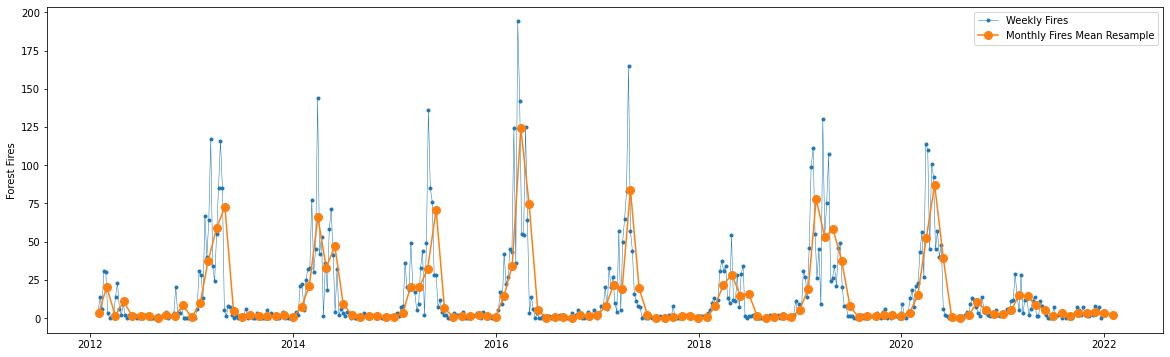

In [5]:
#visualize
y = df["type"]

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly Fires')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Fires Mean Resample')

ax.set_ylabel('Forest Fires')
ax.legend();

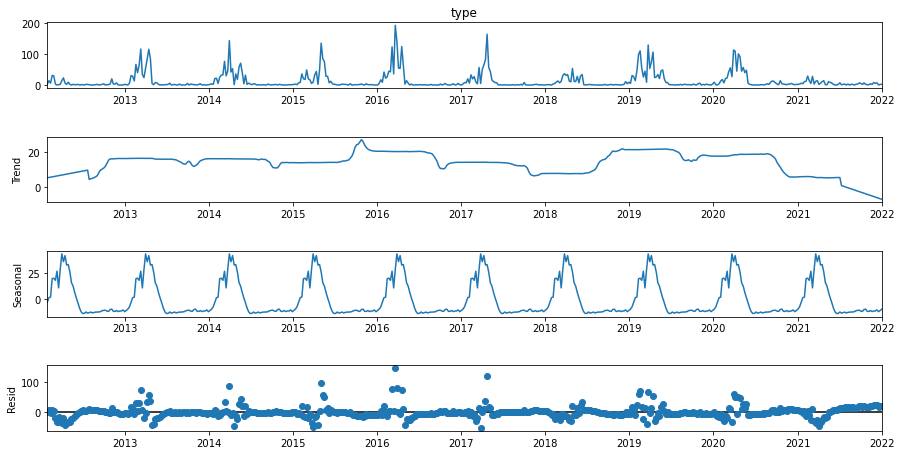

In [6]:
#Decompose the data into observed, trended, seasonal, residual
def seasonal_decompose(y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(y)

Check for stationary data meaning mean, variance and autocorrelation does not change overtime
Need to make it stationary if not.

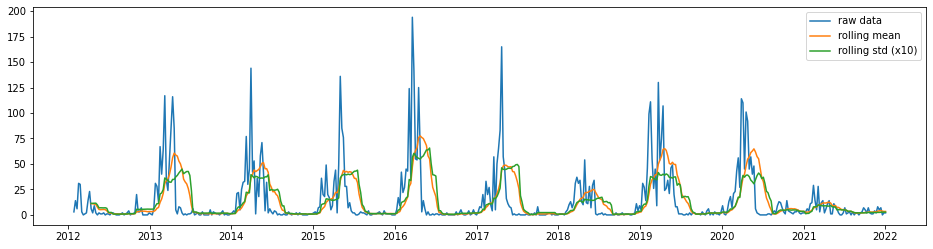

In [7]:
#Visualize to see if the standard deviation changes a lot overtime
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [8]:
# Augmented Dickey-Fuller Test for stationary data by lookin at stats
def ADF_test(timeseries, dataDesc):
    print('Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

        
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -6.003
P-value = 0.000
Critical values :
	1%: -3.443086684769254 - The data is  stationary with 99% confidence
	5%: -2.867157550015396 - The data is  stationary with 95% confidence
	10%: -2.5697619453458325 - The data is  stationary with 90% confidence


In [9]:
#Split the data into training and test data
y_to_train = y[:'2018-05-29'] # dataset to train
y_to_val = y['2018-07-07':] # last X months for test  
predict_date = len(y) - len(y[:'2018-07-07']) # the number of data points for the test set

Models to use for seasonal data are:Holt-Winters’ Seasonal Method and Seasonal ARIMA (SARIMA)

C:\Users\Datura\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


The Root Mean Squared Error of additive seasonal: 21.04
The Root Mean Squared Error of additive damped trend, additive seasonal: 21.57


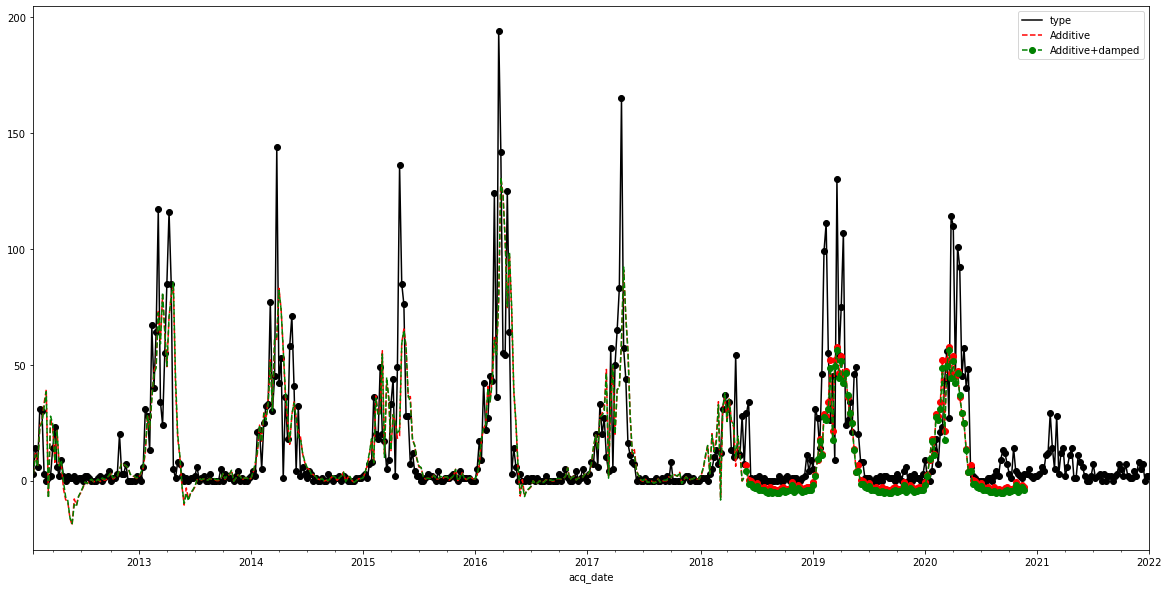

In [21]:
#Holt-Winters’ Seasonal Method
def holt_win_sea(y,y_to_train,y_to_test, seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(20, 10))
    
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, initialization_method='estimated', trend='add', seasonal='add').fit()
    fcast1 = fit1.forecast(predict_date).rename('Additive')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of additive seasonal: {}'.format(round(np.sqrt(mse1), 2)))
        
    fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, initialization_method='estimated', trend='add', seasonal='add', damped_trend=True).fit()
    fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of additive damped trend, additive seasonal: {}'.format(round(np.sqrt(mse2), 2)))
        
    fit1.fittedvalues.plot(style='--', color='red')
    fcast1.plot(style='--', marker='o', color='red', legend=True)
    fit2.fittedvalues.plot(style='--', color='green')
    fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    plt.show()
    
    
holt_win_sea(y, y_to_train, y_to_val,52, predict_date)